Notebook meant for testing Chronos on only a select view clusters.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import arviz as az
import multiprocessing as mp
from functools import partial
import os
import time
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')
import matplotlib
matplotlib.use('widget')
#plt.ioff()  # Turn off interactive plotting

# Add Chronos to path
sys.path.append('/Users/cam/Desktop/astro_research/clusters/Chronos/')
from utils.ExtinctionPrior import ExtinctionPrior
from bayes_fitting.ChronosSkewedCauchy_bayes import ChronosSkewCauchyBayes

# Chronos Functions

In [16]:
def mode_reals(array, bins=100):
    """Calculate the mode of a real-valued array using histogram."""
    counts, bin_edges = np.histogram(array, bins=bins)
    # Take left edges as approximation for bin midpoint
    bins_left_edges = bin_edges[:-1]
    return bins_left_edges[np.argmax(counts)]


def process_cluster_simple(args):
    """
    Simple wrapper function that processes a cluster.
    This needs to be at module level for multiprocessing.
    Accepts either a 3-tuple: (cluster_id, df, ext)
    or a 5-tuple adding priors: (cluster_id, df, ext, bayes_bounds, fitting_kwargs)
    """
    # Unpack args safely to allow optional priors
    if len(args) == 3:
        cluster_id, df, ext = args
        bayes_bounds = None
        fitting_kwargs = None
    else:
        cluster_id, df, ext, bayes_bounds, fitting_kwargs = args

    print(f"Processing cluster: {cluster_id}")
    result = process_single_cluster(cluster_id, df, ext, bayes_bounds=bayes_bounds, fitting_kwargs=fitting_kwargs)
    print(f"Finished cluster: {cluster_id} - Status: {result['status']}")

    return result


def process_single_cluster(cluster_id, data, ext, bayes_bounds=None, fitting_kwargs=None):
    """
    Process a single cluster with Chronos Bayesian fitting.

    Parameters:
    -----------
    cluster_id : str
        Unique identifier for the cluster
    data : pd.DataFrame
        Full dataset containing all clusters
    ext : ExtinctionPrior
        Extinction prior object
    bayes_bounds : dict or None
        Optional priors/bounds to pass to `cbayes.set_bounds`
    fitting_kwargs : dict or None
        Optional kwargs to pass to `cbayes.set_fitting_kwargs`

    Returns:
    --------
    dict
        Dictionary containing the fitted parameters for this cluster
    """
    import gc  # Garbage collection for memory management

    #try:
    # Get cluster data
    df_group = data.groupby('label').get_group(cluster_id)
    extinction_prior = None
    if ext is not None:
        extinction_prior = ext.compute_prior(df_group['ra'], df_group['dec'], distance=df_group['distance_50'])

    age_hunt_myr = df_group['age_myr'].values[0]

    # Set up Chronos fitting
    kwargs = dict(
        data=df_group,
        use_grp=False,
        models='parsec',
        abs_Gmag_name='g_abs_mag',
        color_bprp_name='bp-rp',
        color_grp_name='g-rp'
    )
    cbayes = ChronosSkewCauchyBayes(**kwargs)

    # Use provided priors/bounds if given, otherwise fall back to defaults
    if bayes_bounds is None:
        age_lo, age_hi = 1, 500
        if age_lo < 1:
            age_lo = 1

        av_r = 0, 5.
        lA_r = np.log10(age_lo * 10**6), np.log10(age_hi * 10**6)
        bayes_bounds = dict(
            logAge_range=lA_r,
            feh_range = (-1e-5, 1e-5),
            av_range=av_r,
            skewness_range=(0.5, 0.99),
            scale_range=(0.001, 0.1)
        )

    # Set fitting kwargs and bounds (use provided fitting_kwargs if available)
    if fitting_kwargs is None:
        cbayes.set_fitting_kwargs(fit_range=(-np.infty, 10), do_mass_normalize=False, weights=None)
    else:
        cbayes.set_fitting_kwargs(**fitting_kwargs)
    cbayes.set_bounds(**bayes_bounds)

    # Fit the model with reduced parameters to save memory
    sampler, best_fit, samples_bprp = cbayes.fit_bayesian(nwalkers=40, nsteps=400, burnin=100)

    # Get samples from posterior
    logAge, feh, A_V, skewness, scale = samples_bprp.T
    to_plot = 10**logAge / 10**6, A_V, skewness, scale
    names = 'Age (Myr)', 'AV (mag)', 'Skewness', 'Scale'

    # Create posterior plots
    fig, axes = plt.subplots(1, len(names), figsize=(len(names) * 4, 5))
    for name, data2plot, ax in zip(names, to_plot, axes):
        ax.hist(data2plot, bins=50, histtype='step', color='k')
        ax.hist(data2plot, bins=50, histtype='stepfilled', color='k', alpha=0.25)
        mode_hist = mode_reals(data2plot, bins=100)
        lo, hi = az.hdi(data2plot, hdi_prob=0.64)
        for al in [mode_hist, lo, hi]:
            ax.axvline(al, c='k', alpha=0.5)
        ax.set_xlabel(name)

    # Display posterior plot inline instead of saving to file
    plt.show()
    plt.close()
    plt.clf()

    # Calculate final parameters
    hdi_prob = 0.68
    ages_myr = 10**logAge / 10**6
    age_mode = mode_reals(ages_myr, bins=100)
    age_hdi = az.hdi(ages_myr, hdi_prob=hdi_prob)
    age_lo, age_hi = age_hdi[0], age_hdi[1]

    av_mode = mode_reals(A_V, bins=100)
    av_lo, av_hi = az.hdi(A_V, hdi_prob=hdi_prob)

    # Compute fit info
    _, masses, _ = cbayes.compute_fit_info(
        logAge=np.log10(age_mode * 10**6), feh=0, A_V=av_mode, g_rp=cbayes.use_grp, signed_distance=True
    )

    # Create isochrone plot
    size = 15
    plt.figure(figsize=(6, 9))
    plt.scatter(*cbayes.distance_handler.fit_data['hrd'].T, s=50, c='tab:purple',
                edgecolors='tab:purple', alpha=0.9)
    plt.ylim(14, -4)
    plt.xlim(-1, 5)
    plt.xlabel(r'$G_{BP} - G_{RP}$', size=size)
    plt.ylabel(r'$M_G$', size=size)
    plt.xticks(size=size)
    plt.yticks(size=size)

    # Plot isochrone
    isochrone = cbayes.isochrone_handler.model(
        logAge=np.log10(age_mode * 10**6), feh=0, A_V=av_mode, g_rp=cbayes.use_grp
    )
    plt.plot(*isochrone.T,
                label=r'${{{:.1f}}}^{{+{:.1f}}}_{{{:.1f}}}$ Myr'.format(
                    age_mode, age_hi - age_mode, age_lo - age_mode),
                c='k', alpha=0.7, zorder=0)
    plt.title(r'AV = ${{{:.1f}}}^{{{:.1f}}}_{{{:.1f}}}$ mag'.format(
        av_mode, av_hi - av_mode, av_lo - av_mode), size=size)
    plt.annotate(r'${{{:.1f}}}^{{+{:.1f}}}_{{{:.1f}}}$ Myr'.format(
        age_mode, age_hi - age_mode, age_lo - age_mode),
        (0.98, 0.98), xycoords='axes fraction', ha='right', va='top', size=size)

    # Display isochrone plot inline instead of saving to file
    plt.show()
    plt.close()
    plt.clf()

    # Force garbage collection to free memory
    gc.collect()

    # Return results
    result = {
        'name': cluster_id,
        'age_chronos_mode': age_mode,
        'age_chronos_lo': age_lo,
        'age_chronos_hi': age_hi,
        'av_chronos_mode': av_mode,
        'av_chronos_lo': av_lo,
        'av_chronos_hi': av_hi,
        'status': 'success'
    }

    return result

    # except Exception as e:
    #     return {
    #         'name': cluster_id,
    #         'age_chronos_mode': np.nan,
    #         'age_chronos_lo': np.nan,
    #         'age_chronos_hi': np.nan,
    #         'av_chronos_mode': np.nan,
    #         'av_chronos_lo': np.nan,
    #         'av_chronos_hi': np.nan,
    #         'status': f'error: {str(e)}'
    #     }

# Data

### Read-in

In [3]:
output_file = '/Users/cam/Downloads/hunt_sample_chronos_ages_multiprocessing_feb_2026.csv'
all_results_file = '/Users/cam/Downloads/all_clusters_chronos_results_feb_2026.csv'

df_stars = pd.read_csv('/Users/cam/Downloads/members-2.csv')
df_clusters = pd.read_csv('/Users/cam/Downloads/hunt_partII_partIII_merged.csv')

df_clusters = df_clusters.loc[
    (df_clusters['age_myr'] < 200)
]

### Process

In [4]:
df_stars = df_stars.loc[df_stars['name'].isin(df_clusters['name'])]
df_stars['g_abs_mag'] = df_stars['phot_g_mean_mag'] + 5 - 5 * np.log10(1000 / df_stars['parallax'])
df = df_stars[['name', 'ra', 'dec', 'parallax', 'phot_g_mean_mag', 'phot_bp_mean_mag',
                'phot_rp_mean_mag', 'g_abs_mag', 'bp_rp', 'g_rp']]
df = df.rename(columns={'bp_rp': 'bp-rp', 'g_rp': 'g-rp'})

# Handle distance column - try distance_50 first, fall back to parallax
if 'distance_50' in df_stars.columns:
    df['distance_50'] = df_stars['distance_50']
    print("Using 'distance_50' column for distances")
else:
    df['distance_50'] = 1000 / df['parallax']
    print("Warning: 'distance_50' not found, using parallax-derived distances")

df['label'] = df['name']

# Merge age_myr from df_clusters into df for processing
df = pd.merge(df, df_clusters[['name', 'age_myr']], on='name', how='left')

# Add result columns
df['age_lo'] = np.nan
df['age_hi'] = np.nan
df['av'] = np.nan
df['av_lo'] = np.nan
df['av_hi'] = np.nan

# Select cluster(s)

In [5]:
cluster_name = 'NGC_6405'
cstars = df.loc[df['name'] == cluster_name]

### Plot CMD

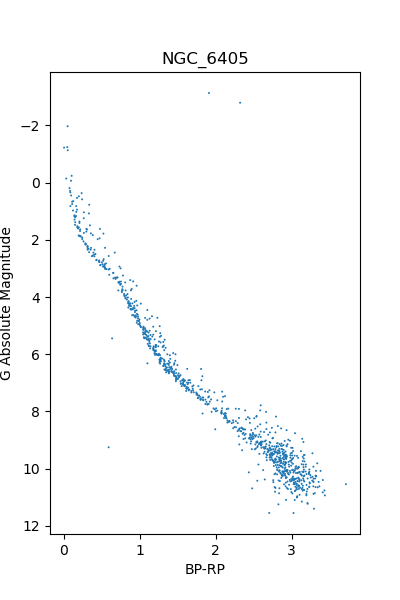

In [6]:
cnames = cstars['name'].unique()
for name in cnames:
    c = cstars.loc[cstars['name'] == name]

    plt.figure(figsize=(4, 6))
    plt.scatter(c['bp-rp'], c['g_abs_mag'], s = 2, edgecolors='none')
    plt.gca().invert_yaxis()
    plt.xlabel('BP-RP')
    plt.ylabel('G Absolute Magnitude')
    plt.title(f'{name}')
    plt.show()

# Run

### Extinction prior

In [7]:
fname_ext = '/Users/cam/Downloads/mean_and_std_healpix.fits'
ext = ExtinctionPrior(fname_ext)

Integrating extinction map (this might take a couple of minutes)...
Optimizing map for querying (this might take a couple of seconds)...


### Priors

In [17]:
# Define priors and fitting kwargs outside the function
bayes_bounds = dict(
    logAge_range=(np.log10(1 * 10**6), np.log10(500 * 10**6)),
    feh_range=(-1e-5, 1e-5),
    av_range=(0, 5),
    skewness_range=(0.5, 0.99),
    scale_range=(0.001, 0.1)
)

fitting_kwargs = dict(fit_range=(-np.infty, 10), do_mass_normalize=False, weights=None)

all_cluster_ids = cstars.label.unique()

In [18]:
for cluster_id in cnames:
    print(f"Processing cluster: {cluster_id}")
    result = process_single_cluster(cluster_id, cstars, ext=None, bayes_bounds=bayes_bounds, fitting_kwargs=fitting_kwargs)
    print(f"Finished cluster: {cluster_id} - Status: {result}")

Processing cluster: NGC_6405
PARSEC isochrones read and processed!


ValueError: No objects to concatenate

In [10]:
cstars.loc[cstars['name'] == cluster_id]

,name,ra,dec,parallax,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,g_abs_mag,bp-rp,g-rp,distance_50,label,age_myr,age_lo,age_hi,av,av_lo,av_hi
279296,NGC_6405,264.923915,-32.226144,2.656172,18.580650,20.396847,17.304989,10.701931,3.091858,1.275662,376.481662,NGC_6405,52.41703,NaN,NaN,NaN,NaN,NaN
279297,NGC_6405,264.899813,-32.246291,2.284974,12.628199,12.990225,12.097497,4.422606,0.892728,0.530702,437.641655,NGC_6405,52.41703,NaN,NaN,NaN,NaN,NaN
279298,NGC_6405,264.919279,-32.240874,2.196665,14.129796,14.640616,13.460604,5.838615,1.180013,0.669192,455.235519,NGC_6405,52.41703,NaN,NaN,NaN,NaN,NaN
279299,NGC_6405,264.685257,-32.149461,2.237936,16.160297,17.380854,15.077964,7.909536,2.302890,1.082334,446.840264,NGC_6405,52.41703,NaN,NaN,NaN,NaN,NaN
279300,NGC_6405,264.722278,-32.126955,2.171450,15.382336,16.111319,14.537895,7.066086,1.573423,0.844440,460.521667,NGC_6405,52.41703,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
280265,NGC_6405,265.036742,-32.146238,1.934551,18.670362,20.491259,17.353468,10.103263,3.137791,1.316895,516.915848,NGC_6405,52.41703,NaN,NaN,NaN,NaN,NaN
280266,NGC_6405,265.025253,-32.159579,2.225589,12.894001,13.276064,12.359764,4.631226,0.916300,0.534237,449.319306,NGC_6405,52.41703,NaN,NaN,NaN,NaN,NaN
280267,NGC_6405,265.052666,-32.159149,2.119752,9.756640,9.796608,9.649567,1.388065,0.147041,0.107073,471.753356,NGC_6405,52.41703,NaN,NaN,NaN,NaN,NaN
280268,NGC_6405,265.087185,-32.136662,2.180312,11.655369,11.901844,11.251815,3.347962,0.650029,0.403554,458.649932,NGC_6405,52.41703,NaN,NaN,NaN,NaN,NaN
